In [1]:
#!/usr/bin/env python
# coding: utf-8

# Sarahfong


# 2019-06-03 - created and run on common variants AF > 0.01

##### updates #####

# 2019-06-10
    # AF calculation was not correct. 0.01<= AF <0.5 is the maf, and 0.5=<AF=<1 is the AF
    # SNPs recalculated as maf.
    # Instead of intersecting only common variants (AF >= 0.01), intersect all variants.
    # maf rounded to 7th decimal


# Analyze the genomic shuffle of FANTOM eRNA enhancers for breaks v. actual transcribed enhancers.


import glob
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
import numpy as np
import os, sys
from scipy import stats
import seaborn as sns
import subprocess

sys.path.append("/dors/capra_lab/users/fongsl/tools/py_/")
import config_readwrite as crw
import plot_params as pp
import split_filename

pp.fonts()

sys.path.append("/dors/capra_lab/users/fongsl/tools/genome/")
import make_windows 
import match_seq_lengths

sys.path.append("/dors/capra_lab/users/fongsl/tools/evo/")
import syn_gen_background 
import linsight

colors = ["faded green", "greyish",  "amber", "dusty purple", "windows blue",]
palette = sns.xkcd_palette(colors)
sns.palplot(palette)

usage: ipykernel_launcher.py [-h] bedfile
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
name = "/dors/capra_lab/users/fongsl/enh_ages/core_v_derived/config_landscape"
config, config_filename = crw.read_config(name)

WINDOW_SIZE = int(config["WINDOWS"]["window_size_10"])
RE = config["LINSIGHT"]["results"]
PY_SCRIPT = config["LINSIGHT"]["bin"]

COMPLEX = config["WINDOWS"][f"complex_windows_{WINDOW_SIZE-1}"] ## file w/ complex bed coords
SIMPLE = config["WINDOWS"][f"simple_windows_{WINDOW_SIZE-1}"]
BREAKS = config["FANTOM"]["data_file"]  # original file on fantom enhancers and breaks. 

COMPLEX_WINDOWS_LINSIGHT = config["LINSIGHT"][f"complex_windows_{WINDOW_SIZE-1}_x_linsight"]
SIMPLE_WINDOWS_LINSIGHT = config["LINSIGHT"][f"simple_windows_{WINDOW_SIZE-1}_x_linsight"]
BUILD = "hg19"

# functions

In [3]:
def calculate_mean_windowlinsight(in_df, enh_id_list):

    """
    return dataframe with the 
    weighted average linsight scores 
    (sum linsight scores divided by the window size) for all enhancers in enh_id_list
    
    inputs - 
        in_df = dataframe w/ enh_id, order_window, window start + end coordinates, linsight scores, n linsight bp overlap

    outputs - 
        df_ = concatenated dataframe from dictionary of weighted average linsight results. 
    
    1. calculate the window length
    2. reduce dataframe to only specific columns
    3. calculate product of linsight score by number of bp w/ score
    4. sum the linsight score product per window
    5. divide linsight score sum per window by window length
    
    """
    i_dict = {}
    
    for i in enh_id_list:
        df = in_df.loc[in_df["enh_id"]==i]

        #1
        df["win_len"] = df["end_win"]-df["start_win"]

        #2
        density_cols = ["core_remodeling", "order_window",  "enh_id","mrca", "win_len", "lin_score", "bp_overlap"]

        df = df[density_cols].drop_duplicates()  # reduce to columns
        df[density_cols[-3:]] = df[density_cols[-3:]].astype(float) # change datatype of len, linscore, overlap


        #3
        df["lin_x_overlap"] = df['lin_score']*df["bp_overlap"] # product of linsight scores x number of bases w/ score
        #4
        df = df.groupby(density_cols[:5])[["lin_x_overlap"]].sum().reset_index()  # sum linsight scores
        #5
        df["mean_lin"] = df["lin_x_overlap"].divide(df["win_len"])
        
        i_dict[i]= df
    
    df_ = pd.concat(i_dict.values())

    return df_

# Windows x LINSIGHT intersection 

In [4]:
fs = [(SIMPLE, SIMPLE_WINDOWS_LINSIGHT),(COMPLEX, COMPLEX_WINDOWS_LINSIGHT)]
for f, out, in fs:
    cmd = f"python {PY_SCRIPT} {f}"
    if os.path.exists(out) is False:

        print(cmd)
        subprocess.call(cmd, shell = True)

## how many shuffled elements are there?

In [5]:
%%bash
cut -f 4,9 /dors/capra_lab/projects/enhancer_ages/fantom/data/non-genic/shuffle_syn_breaks/no-exon_shuf-all_fantom_enh_112_tissues-*_age_breaks.bed | sort | uniq  | cut -f 2 | sort | uniq -c

Process is interrupted.


There are 2657773 shuffled FANTOM enhancers. 

    cut -f 4 /dors/capra_lab/projects/enhancer_ages/fantom/data/non-genic/shuffle_syn_breaks/no-exon_shuf-all_fantom_enh_112_tissues-*_age_breaks.bed | sort | uniq | wc -l
    

shuffled complex N = 1129917 (42.5% of shuffled dataset)


     cut -f 4,9 /dors/capra_lab/projects/enhancer_ages/fantom/data/non-genic/shuffle_syn_breaks/no-exon_shuf-all_fantom_enh_112_tissues-*_age_breaks.bed | sort | uniq  | cut -f 2 | sort | uniq -c

# get simple and 3+ complex enhancers 

In [6]:
cols =["chr_syn", "start_syn", "end_syn", "enh_id", 
                      "chr_enh", "start_enh", "end_enh",
                      "seg_index", "core_remodeling", "core","mrca",]

breaks = pd.read_csv(BREAKS, sep = '\t', header = None, names = cols)

## calculate enhancer length

In [7]:
breaks["enh_len"] = breaks['end_enh']-breaks["start_enh"]

## retrieve enh_ids

In [8]:
threeplus = set(breaks.loc[breaks['seg_index']>2, "enh_id"]) 
simple = set(breaks.loc[breaks['core_remodeling']==0, "enh_id"])
print(len(threeplus), len(simple))

1334 19767


## get dfs for simple and threeplus complex, # specify columns for length matching

In [9]:
match_cols = ["enh_id", "enh_len"]
simple_df = breaks.loc[breaks['enh_id'].isin(simple), match_cols].drop_duplicates()
threeplus_df = breaks.loc[breaks['enh_id'].isin(threeplus), match_cols].drop_duplicates()

## match simple, complex (3+ segments) on length (rounded to 10 bp)

In [10]:
matched_three_ids, matched_simple_ids = match_seq_lengths.match_len(threeplus_df, simple_df, 10, match_cols)

print(len(set(matched_three_ids)), len(set(matched_simple_ids)))

['enh_id', 'enh_len']
1104 2096


# evaluate edge v. center effects of complex and simple windows. 

In [11]:
cols = ['chr_win', 'start_win', "end_win", "order_window", 
        "chr_enh", "start_enh", "end_enh", "mrca", "enh_id", 
        "chr_lin", "start_lin", "end_lin", "lin_score", "bp_overlap"
       ]

simple = pd.read_csv(SIMPLE_WINDOWS_LINSIGHT, sep = '\t', header = None, names = cols)
complex_ = pd.read_csv(COMPLEX_WINDOWS_LINSIGHT, sep = '\t', header = None, names = cols)

/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## distinguish between simple and complex

In [12]:
simple["core_remodeling"], complex_["core_remodeling"] = 0, 1

## subset dataframe into matched enhancers 

In [13]:
# subset simple_df by length matched enhancers
simple_df_matched = simple.loc[simple['enh_id'].isin(matched_simple_ids)]

# subset threeplus df by length matched enhancers
threeplus_df_matched = complex_.loc[complex_['enh_id'].isin(matched_three_ids)]

print(len(simple_df_matched["enh_id"].unique()), len(threeplus_df_matched["enh_id"].unique()))

2065 1104


In [ ]:
import inspect as i
import sys
sys.stdout.write(i.getsource(calculate_mean_windowlinsight))

## calculate weighted average linsight score 

In [14]:
simple_weighted = calculate_mean_windowlinsight(simple_df_matched, matched_simple_ids)

complex_weighted = calculate_mean_windowlinsight(threeplus_df_matched, matched_three_ids)

/home/fongsl/.conda/envs/sfenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
simple_weighted = pd.merge(simple_weighted, breaks.groupby("enh_id")["mrca"].max().reset_index(), how = "left")
complex_weighted = pd.merge(complex_weighted, breaks.groupby("enh_id")["mrca"].max().reset_index(), how = "left")

## remove the last bin (not same window size) as other bins

In [16]:
simple_weighted = simple_weighted.loc[simple_weighted["order_window"]!=11].reset_index()
complex_weighted = complex_weighted.loc[complex_weighted["order_window"]!=11].reset_index()

In [17]:
complex_weighted.head()

,index,core_remodeling,order_window,enh_id,mrca,win_len,lin_x_overlap,mean_lin
0,0,1,1,chr10:6389510-6390540,0.38,94.0,9.751226,0.103736
1,1,1,2,chr10:6389510-6390540,0.38,94.0,6.995640,0.074422
2,2,1,3,chr10:6389510-6390540,0.38,94.0,6.998770,0.074455
3,3,1,4,chr10:6389510-6390540,0.38,94.0,6.432513,0.068431
4,4,1,5,chr10:6389510-6390540,0.38,94.0,6.094921,0.064840


## combine simple and complex weighted LINSIGHT scores

In [18]:
weighted = pd.concat([simple_weighted, complex_weighted])
weighted["mrca"] = weighted["mrca"].round(3)

## add taxon information

In [19]:
weighted = pd.merge(weighted, syn_gen_background.load_syn_gen_bkgd("hg19"), how = "left")

weighted.head()

,index,core_remodeling,order_window,enh_id,mrca,win_len,lin_x_overlap,mean_lin,taxon,mrca_2,taxon2
0,0,0,1,chr12:129301742-129302776,0.175,94.0,7.086833,0.075392,Eutheria,0.175,Eutheria (105)
1,1,0,2,chr12:129301742-129302776,0.175,94.0,7.376720,0.078476,Eutheria,0.175,Eutheria (105)
2,2,0,3,chr12:129301742-129302776,0.175,94.0,7.613051,0.080990,Eutheria,0.175,Eutheria (105)
3,3,0,4,chr12:129301742-129302776,0.175,94.0,6.971068,0.074160,Eutheria,0.175,Eutheria (105)
4,4,0,5,chr12:129301742-129302776,0.175,94.0,7.461268,0.079375,Eutheria,0.175,Eutheria (105)


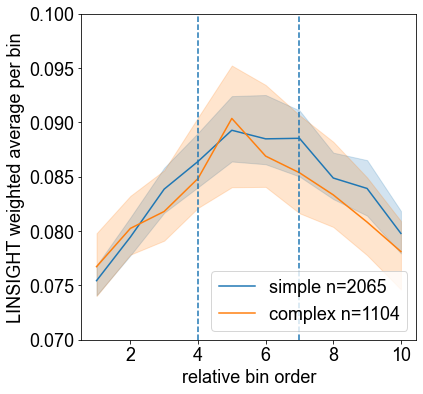

In [34]:
x = "order_window"
y = "mean_lin"
data=weighted
hue = "core_remodeling"
fig, ax = plt.subplots(figsize = (6,6))
sns.lineplot(x=x, y=y, data=data, hue=hue, ax=ax, estimator = np.median,
            #join = False
           )
ax.set(
       xlabel = "relative bin order", ylabel = "LINSIGHT weighted average per bin",
    ylim = (0.07, 0.1)
        )
simplen, complexn = data[["core_remodeling", 'enh_id']].drop_duplicates().groupby("core_remodeling")["enh_id"].count().reset_index()["enh_id"]
ax.legend([f"simple n={simplen}", f"complex n={complexn}"], loc = "lower right")
#ax.axvline((int(WINDOW_SIZE)/2), ls="--")
ax.axvline(4, ls="--")
ax.axvline(7, ls="--")
#ax.axhline(bin_counts_matched[y].mean(), ls="--")
#ax.axhline(simple_df_matched[y].mean(), ls = "--" ,color ="blue")
#ax.axhline(threeplus_df_matched[y].mean(), ls = "--" ,color ="orange")


out = os.path.join(RE, "LINSIGHT_edge_effects.pdf")
plt.savefig(out, bbox_inches = 'tight')


In [36]:
weighted[["enh_id", "win_len"]].drop_duplicates().win_len.describe()

count    3171.000000
mean       41.674866
std        16.738966
min         7.000000
25%        31.000000
50%        37.000000
75%        49.000000
max       132.000000
Name: win_len, dtype: float64

In [26]:
simple_age = data.loc[(data["core_remodeling"]==0)]
complex_age = data.loc[(data["core_remodeling"]==1)]

# compare outer v. inner simple
#print("\nsimple outer v. inner")
simple_stats = outer_v_inner_ages(simple_age)
#print("\ncomplex outer v. inner")

# compare outer v. inner complex
complex_stats = outer_v_inner_ages(complex_age)

In [27]:
simple_stats

[-10.40556261875258, 2.8106622635478134e-25, 0.081, 0.088, 0.101, 0.114]

## functions for comparing inner and outer LINSIGHT scores

In [24]:
def outer_v_inner_ages(df):
    outer_bins = [1,2,3,8,9,10]
    inner_bins = [4,5,6,7]
    
    outer = df.loc[df["order_window"].isin(outer_bins), "mean_lin"]
    inner = df.loc[df["order_window"].isin(inner_bins), "mean_lin"]
    
    stat_t, p =stats.ttest_ind(outer, inner, equal_var = False)
    
    outer_med, inner_med = round(np.median(outer), 3), round(np.median(inner),3)
    outer_std, inner_std = round(np.std(outer), 3), round(np.std(inner),3)
    
    return [stat_t, p, outer_med, inner_med, outer_std, inner_std]

## function for comparing inner linsight scores between simple and complex. 

In [25]:
def arch_v_inner_ages(df1, df2):
    outer_bins = [1,2,3,8,9,10]
    inner_bins = [4,5,6,7]
    
    df1_inner = df1.loc[df1["order_window"].isin(inner_bins), "mean_lin"]
    df2_inner = df2.loc[df2["order_window"].isin(inner_bins), "mean_lin"]

    stat_t, p = stats.ttest_ind(df1_inner, df2_inner, equal_var = False)
    
    med1, med2 = round(np.median(df1_inner), 3), round(np.median(df2_inner),3)
    std1, std2 = round(np.std(df1_inner), 3), round(np.std(df2_inner),3)
    
    return [stat_t, p,  med1, med2, std1, std2]

# plot age-stratified simple and complex enhancers

In [ ]:
ages = [0.957, 0.656, 0.49 , 0.38 ,0.308, 0.175, 0.152, 0.131]#,0.126, 0.0]
results = {}


fig, ax_ = plt.subplots(ncols = 4, nrows = 2, figsize = (32,16))
row = 0

for i, mrca in enumerate(ages):
    if i<4:
        ax = ax_[row][i]
    elif i%4 ==0:
        row = 1
        ax = ax_[row][i-4]
    else:
        ax = ax_[row][i-4]
    #print("\n\n", mrca)
    if mrca !=0:
        x = "order_window"
        y = "mean_lin"
        hue = "core_remodeling"
        data = weighted.loc[weighted["mrca"]==mrca].reset_index()
        title = data["taxon2"].iloc[0]
        
        sns.lineplot(x=x,y=y,data=data, hue=hue, ax=ax, estimator=np.median)

        
        simplen, complexn = data[["core_remodeling", 'enh_id']].drop_duplicates().groupby("core_remodeling")["enh_id"].count().reset_index()["enh_id"]
        ax.legend([f"simple n={simplen}", f"complex n={complexn}"], loc = "upper right")
        ax.set(xlabel=f"bin order",
              ylabel = "LINSIGHT (weighted average per bin)",
               ylim =(0.05, 0.5), 
              title = title)
        ax.axvline(4, ls = "--")
        ax.axvline(7, ls = "--")
   
    simple_age = data.loc[(data["core_remodeling"]==0)]
    complex_age = data.loc[(data["core_remodeling"]==1)]
    
    # compare outer v. inner simple
    #print("\nsimple outer v. inner")
    simple_stats = outer_v_inner_ages(simple_age)
    #print("\ncomplex outer v. inner")
    
    # compare outer v. inner complex
    complex_stats = outer_v_inner_ages(complex_age)
    #print("\nsimple v complex inners")
    
    newdf = pd.DataFrame({
        "mrca_2":[mrca, mrca], 
        "taxon2":[title, title], 
        "arch":["simple", "complex"], 
        "Welch's stats":[simple_stats[0], complex_stats[0]], 
        "Welch's p":[simple_stats[1], complex_stats[1]], 
        "median outer LINSIGHT":[simple_stats[2], complex_stats[2]],
        "median inner LINSIGHT":[simple_stats[3], complex_stats[3]],
        "std outer LINSIGHT":[simple_stats[4], complex_stats[4]],
        "std inner LINSIGHT":[simple_stats[5], complex_stats[5]],
        "n":[simplen, complexn]
           })
    results[mrca] = newdf
    # compare inner simple v. complex
    arch_v_inner_ages(simple_age, complex_age)
out = os.path.join(RE, "LINSIGHT_edge_effects-AgeStratified.pdf")
plt.savefig(out)

In [ ]:
result_stats = pd.concat(results.values())
out = os.path.join(RE, "LINSIGHT_edge_effects-AgeStratified.tsv")
result_stats.to_csv(out, sep = '\t', index = False)